# A. Setup e Dataset

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

from dataset import BaseSegmentationDataset, build_mapping_array
from model_uos import DeepLabUOS
from conformal_prediction import calibrate_conformal, conformal_mask
from train_eval import evaluate_metrics, calculate_mIoU  # Assicurati di avere calculate_mIoU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

CITYSCAPES_ROOT = "datasets/realcityscapes"
LOSTANDFOUND_ROOT = "datasets/lostandfound"


mapping_array = build_mapping_array(unknown_obstacle_id=7)

transform = torch.nn.Sequential()  # usa ToTensor() di default nel dataset

train_dataset = BaseSegmentationDataset(
    img_dir=os.path.join(CITYSCAPES_ROOT, 'leftImg8bit/train'),
    label_dir=os.path.join(CITYSCAPES_ROOT, 'gtFine/train'),
    mapping_array=mapping_array,
    transform=None,
    ood_mode=False
)

val_dataset = BaseSegmentationDataset(
    img_dir=os.path.join(CITYSCAPES_ROOT, 'leftImg8bit/val'),
    label_dir=os.path.join(CITYSCAPES_ROOT, 'gtFine/val'),
    mapping_array=mapping_array,
    transform=None,
    ood_mode=False
)

test_dataset = BaseSegmentationDataset(
    img_dir=os.path.join(LOSTANDFOUND_ROOT, 'leftImg8bit/test'),
    label_dir=os.path.join(LOSTANDFOUND_ROOT, 'gtCoarse/test'),
    mapping_array=mapping_array,
    transform=None,
    ood_mode=True
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


✅ Device: cuda


# Utils

In [ ]:
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            logits = out["logits"]
            loss = criterion(logits, labels)
            val_loss += loss.item()
    return val_loss / len(val_loader)



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_full_paper_style(img, gt_multi, gt_ood_filtered, pred_ood, title="OoD Detection (Small Obstacles Only)"):
    """
    img: torch.Tensor [C,H,W], valori [0,1]
    gt_multi: np.array [H,W], valori macro-classi (0..7)
    gt_ood_filtered: np.array [H,W], 0/1 (solo piccoli ostacoli)
    pred_ood: np.array [H,W], 0/1 (OoD prediction)
    """
    # ---- 1. Input Image ----
    img_np = (img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

    # ---- 2. GT Multi-class Colorata ----
    gt_color = decode_segmap(gt_multi)

    # ---- 3. Confusion Overlay ----
    overlay = np.copy(img_np)
    tp = (gt_ood_filtered == 1) & (pred_ood == 1)
    fp = (gt_ood_filtered == 0) & (pred_ood == 1)
    fn = (gt_ood_filtered == 1) & (pred_ood == 0)

    overlay[tp] = [0, 255, 0]    # Verde = TP
    overlay[fp] = [255, 0, 0]    # Rosso = FP
    overlay[fn] = [0, 0, 255]    # Blu = FN

    blended = cv2.addWeighted(img_np, 0.5, overlay, 0.5, 0)

    # ---- 4. Plot a 4 riquadri ----
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(img_np)
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(gt_color)
    plt.title("GT Multi-class")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(gt_ood_filtered, cmap="gray")
    plt.title("GT OoD (Small Obstacles)")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(blended)
    plt.title("Overlay TP(G)/FP(R)/FN(B)")
    plt.axis("off")

    plt.suptitle(title)
    plt.show()


In [ ]:
def filter_small_ood(gt_mask, max_size=5000):
    """
    gt_mask: np.array [H,W], valori 0/1 (OoD binario)
    max_size: max pixel per considerare un blob come ostacolo
    """
    filtered = np.zeros_like(gt_mask, dtype=np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(gt_mask.astype(np.uint8), connectivity=8)
    
    for i in range(1, num_labels):  # 0 = background
        if stats[i, cv2.CC_STAT_AREA] <= max_size:
            filtered[labels == i] = 1
    return filtered


In [ ]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

def plot_roc_pr(all_scores, all_gts, title_suffix="(OoD Small Obstacles)"):
    plt.figure(figsize=(12, 5))

    # ROC
    plt.subplot(1, 2, 1)
    RocCurveDisplay.from_predictions(all_gts, all_scores)
    plt.title(f"ROC Curve {title_suffix}")

    # PR Curve
    plt.subplot(1, 2, 2)
    PrecisionRecallDisplay.from_predictions(all_gts, all_scores)
    plt.title(f"Precision-Recall Curve {title_suffix}")

    plt.show()

In [ ]:
import numpy as np

# Tavolozza macro-classi (uguale al dataset)
COLORS = np.array([
    (128, 64, 128),   # 0 - Road
    (244, 35, 232),   # 1 - Flat
    (220, 20, 60),    # 2 - Human
    (0, 0, 142),      # 3 - Vehicle
    (153, 153, 153),  # 4 - Construction
    (250, 170, 30),   # 5 - Objects
    (107, 142, 35),   # 6 - Vegetation
    (255, 255, 255),  # 7 - OoD (Unknown)
], dtype=np.uint8)

def decode_segmap(mask):
    """Converte una mask [H,W] in un'immagine RGB colorata"""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id, color in enumerate(COLORS):
        color_mask[mask == cls_id] = color
    return color_mask


In [ ]:
def plot_full_comparison(img, gt_multi, gt_ood, pred_ood, title="OoD Detection"):
    # ✅ L'immagine è già in [0,1], non serve de-normalizzare
    img_np = img.permute(1, 2, 0).cpu().numpy()

    gt_color = decode_segmap(gt_multi)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(img_np)
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(gt_color)
    plt.title("GT Multi-class")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(gt_ood, cmap="gray")
    plt.title("GT OoD")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(pred_ood, cmap="gray")
    plt.title("Prediction OoD")
    plt.axis("off")

    plt.suptitle(title)
    plt.show()


In [ ]:
def plot_confusion_overlay(img, gt_ood, pred_ood, title="OoD Confusion Overlay"):
    """
    img: torch.Tensor [C,H,W] (0-1)
    gt_ood: np.array [H,W] (0/1)
    pred_ood: np.array [H,W] (0/1)
    """
    img_np = (img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

    # TP=verde, FP=rosso, FN=blu
    overlay = np.copy(img_np)
    tp = (gt_ood == 1) & (pred_ood == 1)
    fp = (gt_ood == 0) & (pred_ood == 1)
    fn = (gt_ood == 1) & (pred_ood == 0)

    overlay[tp] = [0, 255, 0]    # Verde
    overlay[fp] = [255, 0, 0]    # Rosso
    overlay[fn] = [0, 0, 255]    # Blu

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.addWeighted(img_np, 0.5, overlay, 0.5, 0))
    plt.title(title)
    plt.axis("off")
    plt.show()

In [ ]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

def plot_roc_pr(all_scores, all_gts):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    RocCurveDisplay.from_predictions(all_gts, all_scores)
    plt.title("ROC Curve (OoD)")

    plt.subplot(1, 2, 2)
    PrecisionRecallDisplay.from_predictions(all_gts, all_scores)
    plt.title("Precision-Recall Curve (OoD)")

    plt.show()


# B. Modello + Training (Poly LR + Best mIoU)

In [2]:
n_classes = 7
model = DeepLabUOS(n_classes=n_classes, normalize_uos=True).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)

MODEL_PATH = "deeplab_uos_trained.pth"
EPOCHS = 1
start_epoch = 0
best_mIoU = 0.0

if os.path.exists(MODEL_PATH):
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    if "optimizer_state" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint.get("epoch", -1) + 1
    best_mIoU = checkpoint.get("mIoU", 0.0)
    print(f"✅ Riprendo da Epoch {start_epoch} (Best mIoU {best_mIoU:.4f})")
else:
    print("⚠️ Nessun modello trovato, training da zero.")


✅ Riprendo da Epoch 21 (Best mIoU 0.7630)


C:\Users\colam\AppData\Local\Temp\ipykernel_25636\3928807046.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


In [ ]:

max_iter = (EPOCHS + start_epoch) * len(train_loader)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda it: (1 - it / max_iter) ** 0.9)

train_losses, val_mious = [], []

for epoch in range(start_epoch, EPOCHS + start_epoch):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS+start_epoch}", leave=False)

    for imgs, labels in progress_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        logits = out["logits"]
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{epoch_loss / (progress_bar.n + 1):.4f}"})

    avg_loss = epoch_loss / len(train_loader)
    val_mIoU = calculate_mIoU(model, val_loader)
    train_losses.append(avg_loss)
    val_mious.append(val_mIoU)
    print(f"Epoch {epoch+1}/{EPOCHS+start_epoch} - Train Loss: {avg_loss:.4f} | Val mIoU: {val_mIoU:.4f}")

    if val_mIoU > best_mIoU:
        best_mIoU = val_mIoU
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "mIoU": best_mIoU
        }, MODEL_PATH)
        print(f"✅ Miglior modello aggiornato (Val mIoU: {best_mIoU:.4f})")

print(f"🏁 Training completato! Best Val mIoU finale: {best_mIoU:.4f}")


# C. Testing con filtro ostacoli grandi

In [3]:
#debug una tantum
ex=False
if ex:
    sizes = []
    with torch.no_grad():
        for _, labels in test_loader:
            gt_mask = (labels.squeeze(0).numpy() == 7).astype(np.uint8)
            num_labels, _, stats, _ = cv2.connectedComponentsWithStats(gt_mask, connectivity=8)
            for i in range(1, num_labels):
                sizes.append(stats[i, cv2.CC_STAT_AREA])

    plt.figure(figsize=(8,4))
    plt.hist(sizes, bins=50)
    plt.title("Distribuzione dimensioni blob OoD")
    plt.xlabel("Area (pixel)")
    plt.ylabel("Count")
    plt.show()

    print("Max blob size:", max(sizes), "Min:", min(sizes))


✅ Conformal threshold q̂: 0.8217059373855591


Testing: 100%|██████████| 1203/1203 [01:54<00:00, 10.46it/s]


OoD pixel count (filtered): 128788349
AUROC: 0.7824 | AP: 0.9330 | FPR95: 0.7453
OoD pixel count: 128788349
Scores range: 4.4489945e-09 0.9998539


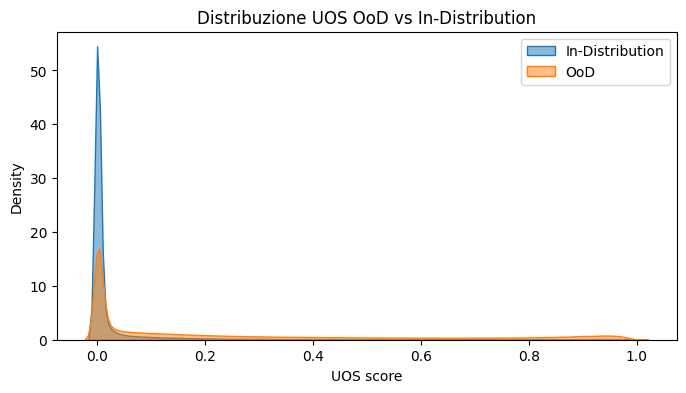

In [7]:
def filter_exclude_giant(gt_mask, max_exclude=80000):
    """
    Mantiene tutti i blob OoD tranne quelli giganti (area > max_exclude)
    """
    filtered = np.copy(gt_mask)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(gt_mask, connectivity=8)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > max_exclude:
            filtered[labels == i] = 0
    return filtered


# ---- Calibrazione conformale ----
calib_scores = []
model.eval()
with torch.no_grad():
    for imgs, _ in val_loader:
        uos = model(imgs.to(device))["uos"]
        calib_scores.append(uos.cpu().numpy())

calib_scores = np.concatenate(calib_scores).flatten()
alpha = 0.1
qhat = calibrate_conformal(calib_scores, alpha=alpha)
print(f"✅ Conformal threshold q̂: {qhat}")

# ---- Testing ----
all_scores, all_gts = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        out = model(imgs.to(device))
        uos = out["uos"].cpu().numpy()

        # ✅ Smoothing spaziale (applicato per ogni immagine nel batch)
        for i in range(uos.shape[0]):
            uos[i, 0] = cv2.GaussianBlur(uos[i, 0], (5, 5), 0)

        # GT OoD binaria
        gt_mask = (labels.squeeze(0).numpy() == 7).astype(np.uint8)
        gt_mask_filtered = filter_exclude_giant(gt_mask, max_exclude=120000)

        all_scores.append(uos)
        all_gts.append(gt_mask_filtered)


print("OoD pixel count (filtered):", np.sum(all_gts))
all_scores = np.concatenate(all_scores).flatten()
all_gts = np.concatenate(all_gts).flatten()

metrics = evaluate_metrics(all_scores, all_gts)
print(f"AUROC: {metrics['AUROC']:.4f} | AP: {metrics['AP']:.4f} | FPR95: {metrics['FPR95']:.4f}")

print("OoD pixel count:", np.sum(all_gts))
print("Scores range:", all_scores.min(), all_scores.max())

import seaborn as sns

ood_scores = all_scores[all_gts == 1]
ind_scores = all_scores[all_gts == 0]

plt.figure(figsize=(8,4))
sns.kdeplot(ind_scores, label="In-Distribution", fill=True, alpha=0.5)
sns.kdeplot(ood_scores, label="OoD", fill=True, alpha=0.5)
plt.title("Distribuzione UOS OoD vs In-Distribution")
plt.xlabel("UOS score")
plt.ylabel("Density")
plt.legend()
plt.show()



# D. Visualizzazioni (Paper Style)

In [19]:
def filter_only_small_ood(gt_mask, max_size=20000):
    filtered = np.zeros_like(gt_mask, dtype=np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(gt_mask, connectivity=8)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] <= max_size:
            filtered[labels == i] = 1
    return filtered

# ---- Testing SOLO OSTACOLI ----
all_scores, all_gts = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        out = model(imgs.to(device))
        uos = out["uos"].cpu().numpy()

        # ✅ GT OoD binaria: ostacoli = 1
        gt_mask = (labels.squeeze(0).numpy() == 7).astype(np.uint8)
        gt_mask_filtered = filter_only_small_ood(gt_mask, max_size=20000)

        all_scores.append(uos)
        all_gts.append(gt_mask_filtered)

all_scores = np.concatenate(all_scores).flatten()
all_gts = np.concatenate(all_gts).flatten()

print("OoD pixel count (filtered):", np.sum(all_gts))
metrics = evaluate_metrics(all_scores, all_gts)
print(f"AUROC: {metrics['AUROC']:.4f} | AP: {metrics['AP']:.4f} | FPR95: {metrics['FPR95']:.4f}")


Testing: 100%|██████████| 1203/1203 [02:02<00:00,  9.81it/s]


OoD pixel count (filtered): 106
AUROC: 0.9146 | AP: 0.0000 | FPR95: 0.2066


In [22]:
COLORS = np.array([
    (128, 64, 128),   # 0 - Road
    (244, 35, 232),   # 1 - Flat
    (220, 20, 60),    # 2 - Human
    (0, 0, 142),      # 3 - Vehicle
    (153, 153, 153),  # 4 - Construction
    (250, 170, 30),   # 5 - Objects
    (107, 142, 35),   # 6 - Vegetation
    (255, 255, 255),  # 7 - OoD
], dtype=np.uint8)

def decode_segmap(mask):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id, color in enumerate(COLORS):
        color_mask[mask == cls_id] = color
    return color_mask

def plot_full_paper_style(img, gt_multi, gt_ood_filtered, pred_ood, title="OoD Detection"):
    img_np = (img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    gt_color = decode_segmap(gt_multi)

    overlay = np.copy(img_np)
    tp = (gt_ood_filtered == 1) & (pred_ood == 1)
    fp = (gt_ood_filtered == 0) & (pred_ood == 1)
    fn = (gt_ood_filtered == 1) & (pred_ood == 0)
    overlay[tp] = [0, 255, 0]
    overlay[fp] = [255, 0, 0]
    overlay[fn] = [0, 0, 255]
    blended = cv2.addWeighted(img_np, 0.5, overlay, 0.5, 0)

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, 1); plt.imshow(img_np); plt.title("Input"); plt.axis("off")
    plt.subplot(1, 4, 2); plt.imshow(gt_color); plt.title("GT Multi-class"); plt.axis("off")
    plt.subplot(1, 4, 3); plt.imshow(gt_ood_filtered, cmap="gray"); plt.title("GT OoD (Filtered)"); plt.axis("off")
    plt.subplot(1, 4, 4); plt.imshow(blended); plt.title("TP(G)/FP(R)/FN(B)"); plt.axis("off")
    plt.suptitle(title); plt.show()


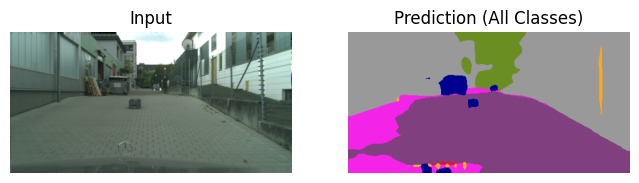

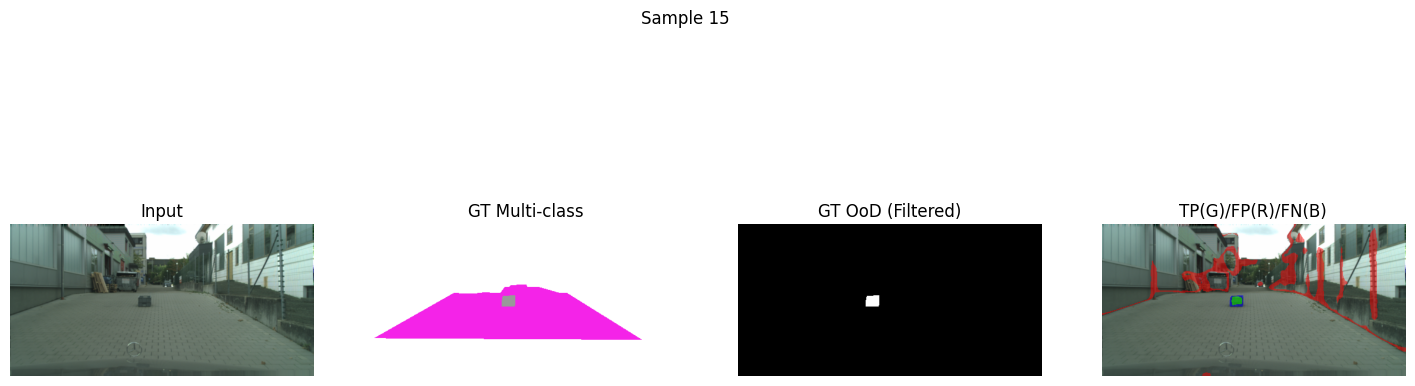

In [36]:
with torch.no_grad():
    for idx, (imgs, labels) in enumerate(test_loader):
        if idx < 15:
            continue
        imgs = imgs.to(device)
        out = model(imgs)

        # ✅ Estrai la mappa UOS e applica smoothing
        uos_map = out["uos"].cpu().numpy()[0, 0]
        uos_map = cv2.GaussianBlur(uos_map, (5, 5), 0)  # Smoothing spaziale

        # ✅ Applica il conformal threshold sui punteggi smussati
        pred_mask = (uos_map > qhat).astype(np.uint8)
        pred_mask_c = out["logits"].argmax(dim=1).squeeze(0).cpu().numpy()
        plot_model_prediction(imgs[0], pred_mask_c, title="Prediction (All Classes)")
        # ✅ GT OoD filtrata (blob giganti esclusi)
        lbl_np = labels.squeeze(0).numpy()
        #print(lbl_np)
        gt_mask_ood = (lbl_np == 4).astype(np.uint8)
        gt_mask_ood_filtered = filter_only_small_ood(gt_mask_ood, max_size=120000)

        # ✅ Plot completo in stile paper
        plot_full_paper_style(imgs[0], lbl_np, gt_mask_ood, pred_mask, title=f"Sample {idx}")
        break


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Tavolozza (macro-classi)
COLORS = np.array([
    (128, 64, 128),   # 0 - Road
    (244, 35, 232),   # 1 - Flat
    (220, 20, 60),    # 2 - Human
    (0, 0, 142),      # 3 - Vehicle
    (153, 153, 153),  # 4 - Construction
    (250, 170, 30),   # 5 - Objects
    (107, 142, 35),   # 6 - Vegetation
    (255, 255, 255),  # 7 - Unknown / OoD
], dtype=np.uint8)

def decode_segmap(mask):
    """Converte una mask [H,W] di classi in immagine RGB colorata"""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id, color in enumerate(COLORS):
        color_mask[mask == cls_id] = color
    return color_mask

def plot_model_prediction(img, pred_mask, title="Model Prediction"):
    """
    img: torch.Tensor [C,H,W]
    pred_mask: np.array [H,W] con classi (0..7)
    """
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalizza [0,1]
    pred_color = decode_segmap(pred_mask)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_color)
    plt.title(title)
    plt.axis("off")
    plt.show()
